# Receiving FT8

This notebook receives FT8 messages using the methods described by the source code of WSJT-X Version 2.1
[[1]](#References).

This notebook uses the following Python libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io.wavfile
import ft8

While the high-level algorithms used here are based on those used in WSJT-X, some of the low-level algorithms
may be slightly different from those used in WSJT-X, in order to take advantage of the Python numerical libraries
`numpy` and `scipy`.

## Table of Contents

* [Overview](#Overview)
* [FT8 Signal Parameters](#FT8-Signal-Parameters)
* [Signal Acquisition and Sample Rate Conversion](#Signal-Acquisition-and-Sample-Rate-Conversion)
* [Candidate Signal Identification](#Candidate-Signal-Identification)
    * [Spectrogram](#Spectrogram)
    * [Noise Baseline](#Noise-Baseline)
    * [Costas Array Cross-Correlation](#Costas-Array-Cross-Correlation)
    * [Candidate Selection](#Candidate-Selection)
* [Full Receive Spectrum](#Full-Receive-Spectrum)
* [Candidate Signal Extraction](#Candidate-Signal-Extraction)
* [Frequency Correction and Time Offset Estimation](#Frequency-Correction-and-Time-Offset-Estimation)
* [Detection](#Detection)
    * [Demodulation and Costas Array Hard Detection](#Demodulation-and-Costas-Array-Hard-Detection)
    * [Soft Demapping](#Soft-Demapping)
* [LDPC Decoding and CRC Check](#LDPC-Decoding-and-CRC-Check)
* [Source Decoding](#Source-Decoding)
* [References](#References)
* [License](#License)

## Overview

WSJT-X receives FT8 signals in two major processing phases.

1. A spectral analysis phase that is performed once for every 15 second receive period.
1. A candidate signal processing phase that is performed for each candidate signal
that is identified by the spectral analysis phase.

### Spectral Analysis

The first phase is performed once per 15 second receive period and is illustrated in the following diagram:

![Spectral Analysis](drawings/Spectral%20Analysis.svg)

The first phase of processing involves the following steps:
1. Signal acquisition.
This can be reading samples from a WAV file or reading samples directly from an audio codec.
This notebook only supports signal acquisition from a WAV file.
1. Sample rate conversion.
No matter the sample rate used to initially acquire the signal, the initial signal processing
within WSJT-X is oriented around a sample rate of 12000 samples per second.
Therefore if the sample rate of the signal acquisition is not this value, conversion to
this sample rate will be required.
1. Candidate signal identification.
This uses the Costas arrays embedded in each FT8 signal to identify candidate FT8 signal intermediate
frequencies within the receiver passband,
along with the relative time offset of the start of each candidate FT8 signal.
It is comprised of 3 stages:
    1. Calculation of the spectrogram and noise baseline
    1. Cross-correlation with Costas arrays
    1. Candidate selection
1. Full receive spectrum.
A real DFT of the entire 15 second receive period is calculated to generate a full receive spectrum
that can subsequently be used by the second processing phase.

At the end of the first phase, we have a list of candidate FT8 signals, for which we have estimated
the frequency and time offset relative to the local oscillator and clock.
We also have a high resolution complex spectrum for the entire 15 second receive period and a noise
baseline that can be used to estimate signal to noise ratios.

In this notebook the first phase of processing is performed by the `ft8.SpectralAnalysis` class.

### Candidate Signal Processing

The second phase of processing is typically performed multiple times in each 15 second receive period,
once for each candidate FT8 signal,
and is illustrated in the following diagram:

![Signal Processing](drawings/Signal%20Processing.svg)

The second phase of processing involves the following steps:

1. Candidate signal extraction.
This extracts the candidate FT8 signal from the full receive spectrum using a narrow bandpass filter, and moves
the signal to baseband, so that the lowest tone in the signal falls approximately at 0 Hz.
The signal is then converted from the frequency domain to the time domain using the inverse DFT.
1. High resolution estimation of frequency and time offset.
This ensures the lowest tone in the candidate FT8 signal is as close to 0 Hz as possible and improves the
estimate of the time offset.
1. Detection.
This demodulates the baseband signal, and after a sanity check
estimates log likelyhood ratios for each bit position in the candidate FT8 signal.
1. Channel Decoding.
This attempts to determine the original 77 bit message and associated 14 bit CRC using a LDPC decoder
and then checks that the CRC matches the message.
1. Source Decoding (Unpacking).
The 77 bit message is unpacked to obtain the original message text.

In this notebook the second phase of processing is primarily implemented by the `ft8.Signal` class.

## FT8 Signal Parameters

The FT8 digital mode has evolved over its short history.
At the time this notebook was developed, the most recent version of the FT8 digital mode was that defined
by the source code of WSJT-X 2.1.
This version of the FT8 digital mode was a minor revision to that defined by the source code of WSJT-X 2.0.
The FT8 digital mode implementations in WSJT-X 2.0 and 2.1 are interoperable.

Earlier versions of the FT8 digital mode are not compatible with those defined by the code in WSJT-X 2.0 and 2.1,
and are not considered in this notebook.

The main parameters of FT8 signals as implemented in WSJT-X 2.0 are:

* Transmit and receive occurs in alternating 15 second cycles starting at the 0, 15, 30 or 45 second mark in each minute.
* The modulated signal commences 0.5 seconds after the start of a 15 second transmit cycle.
* Messages are packed (source encoded) into 77 bits using a unique lossless compression scheme.
See [FT8 Message Packing](Packing.ipynb).
* A 14 bit CRC is appended to each message resulting in 91 bits. See [FT8 Coding Notes - CRC Codes](Coding.ipynb#CRC-Codes).
* A LDPC code is applied generating 83 additional parity bits which expands the message to 174 bits.
See [FT8 Coding Notes - LDPC Codes](Coding.ipynb#LDPC-Codes).
* The 174 bits are grouped into 58 x 3 bit symbols which are then gray coded.
See [FT8 Coding Notes - Gray Codes](Coding.ipynb#Gray-Codes).
* The 58 gray coded symbols are combined with 3 x 7th order Costas arrays resulting in 79 tones.
The Costas arrays are inserted at the beginning, middle and end of the message symbols.
* The 79 message and Costas array tones are transmitted using continuous phase M-FSK modulation, with M=8.
* By convention, the transmit frequency is the frequency of the lowest M-FSK tone.
* The M-FSK modulation baud rate is 12000 / 1920 = 6.25 symbols per second
* The M-FSK modulation tone spacing is the same as the baud rate or 6.25 Hz.
This ensures the tones can be considered orthogonal when the receiver uses non-coherent detection methods.
* The transmit duration is 79 / 6.25 or 12.65 seconds
* Most of the transmit power is confined to a 50 Hz bandwidth, extending from 3.125 Hz below the transmit frequency to
46.875 Hz above the transmit frequency.

WJST-X 2.1 makes one modification to these parameters:
* The M-FSK modulation is shaped by a gaussian filter to reduce sidelobes to become M-GFSK modulation.

These parameters are captured by the constants defined in the `ft8` Python module as illustrated below.

In [2]:
def dump_constants():
    # FT8 Constants from ft8.py
    print("Transmit/Receive Period = {} seconds".format(ft8.tr_period))
    print("Transmit start delay = {} seconds".format(ft8.start_delay))
    print("Baud rate = {} baud".format(ft8.baud_rate))
    print("Frequency shift (tone separation) = {} Hz".format(ft8.freq_shift))
    print("Number of tones = {}".format(ft8.tone_count))
    print("Gaussian filter bandwidth = {} baud rate\n".format(ft8.gaussian_bandwidth))

    print("Message bits = {}".format(ft8.msg_bits))
    print("CRC bits = {}".format(ft8.crc_bits))
    print("CRC polynomial = 0x{:X}".format(ft8.crc_polynomial))
    print("LDPC parity bits = {}".format(ft8.ldpc_parity_bits))
    print("Encoded bits = {}\n".format(ft8.encoded_bits))

    print("Costas array tones = {}".format(ft8.costas))
    print("Costas array offsets = {}".format(ft8.costas_offsets))
    print("Costas array order = {}\n".format(ft8.costas_order))

    print("Gray coding map = {}".format(ft8.gray_map))
    print("Symbol offsets = {}".format(ft8.symbol_offsets))
    print("Encoded symbols = {}\n".format(ft8.encoded_symbols))

    print("Total symbols = {}".format(ft8.total_symbols))

In [3]:
dump_constants()

Transmit/Receive Period = 15 seconds
Transmit start delay = 0.5 seconds
Baud rate = 6.25 baud
Frequency shift (tone separation) = 6.25 Hz
Number of tones = 8
Gaussian filter bandwidth = 2.0 baud rate

Message bits = 77
CRC bits = 14
CRC polynomial = 0x2757
LDPC parity bits = 83
Encoded bits = 174

Costas array tones = [3, 1, 4, 0, 6, 5, 2]
Costas array offsets = [0, 36, 72]
Costas array order = 7

Gray coding map = [0, 1, 3, 2, 5, 6, 4, 7]
Symbol offsets = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Encoded symbols = 58

Total symbols = 79


## Signal Acquisition and Sample Rate Conversion

Prior to FT8 decoding we need to acquire FT8 signals at suitable intermediate frequencies.

FT8 signals are typically sourced by connecting the audio output of an SSB transceiver
(set to upper sideband), to the line or microphone input of an audio codec.
Note that some SSB transceivers may have integrated audio codecs.
The intermediate frequencies of the candidate signals needs to fall within the receiver passband
which is typically in the range of 100 Hz to 3000 Hz.

WSJT-X expects audio codecs to be configured to use a sample rate of 48000 samples per second.
However, the initial digital signal processing within WSJT-X is performed at a sample rate of
12000 samples per second.
Therefore, sample rate conversion from 48000 samples per second to 12000 samples per second is required.

Sample rate conversion is performed by WSJT-X in the time domain,
using a 49 tap finite impulse response (FIR) low pass filter.
The filter is implemented by the `fil4` subroutine in the `lib/filt4.f90` compilation unit.

Alternatively WSJT-X can acquire a raw signal from a pre-recorded WAV file of the following format:
* 12000 samples per second
* 16-bit signed integer little endian linear PCM samples
* 1 channel (mono)
* 15 second recording duration

No sample rate conversion is required for such WAV files, as they already use the same sample rate as
the initial digital signal processing within WSJT-X.

This notebook only supports signal acquisition from a WAV file of the same format expected by WSJT-X.
The Python `scipy` library provides suitable functions for reading and writing WAV files as illustrated
below for a recording that was taken on February 28th, 2019.

In [39]:
if_sample_rate, if_samples = scipy.io.wavfile.read('audio/190228_105600.wav')

print("IF Sample rate = {} samples per second".format(if_sample_rate))
print("Sample count = {} samples".format(if_samples.size))
print("Recording duration = {} seconds".format(if_samples.size / if_sample_rate))

IF Sample rate = 12000 samples per second
Sample count = 180000 samples
Recording duration = 15.0 seconds


## Candidate Signal Identification

Prior to decoding individual FT8 signals, the we need to identify candidate FT8 signals in the
receiver passband and determine both their 
base frequency relative to the local oscillator, and their start time offset relative to local time.
This is necessary as the transmit time/oscillator and receive time/oscillator are assumed to be
unsynchronized.

This processing step exploits the Costas array signals that are embedded in each FT8 signal
for synchronization purposes.
Costas array signals are embedded at the start, middle and end of each FT8 signal.

Costas arrays were originally conceived in the mid-1960s to identify frequency doppler shift and time delay in
SONAR applications using the statistical technique of correlation
[[2](#References)].
In the FT8 digital mode, the Costas arrays serve a very similar purpose,
in that they allow the identification of a FT8 signal frequency and start time
offset.

The key property of Costas array signals is they have a very strongly defined peak in their auto-ambiguity
function.
This characterstic can be exploited to determine the frequency and time offset of a signal containing a
Costas array by performing cross-correlation of that signal with a reference Costas array signal.

The initial candidate signal identification is performed in the frequency domain using spectral analysis.
Time domain samples of the raw signal are first converted to the frequency domain using the discrete
Fourier transform (DFT) to allow frequency domain processing.

The initial candidate signal identification can only perform a coarse estimate for freqency and time offset.
Subsequent processing of each candidate signal is requried to perform a more precise high resolution estimate for
the frequency and time offset.
This subsequent processing is performed in the time domain.

In WSJT-X, the initial candidate signal identification is peformed by the `sync8` subroutine,
which can be found in the `lib/ft8/sync8.f90` compilation unit.

The algorithm used for candidate FT8 signal identification in WSJT-X is as follows:

1. Compute a spectrogram of the samples received in a 15 second transmit/receive interval.
The spectrogram is comprised of a series of overlapping periodograms that are calculated from the received
samples using the DFT.
The periodograms are separated in time by 1/4 of the symbol time or 1/25th of a second.
Each periodogram covers the frequency range of zero through half the sample rate or 6000 Hz.
The frequency resolution of each periodogram is 1/2 of the M-GFSK frequency shift or 3.125 Hz.
1. Compute a noise baseline from the spectrogram.
The noise baseline is subsequently used to determine the signal to noise ratio of successfully decoded signals.
2. Search the spectrogram for candidate FT8 signals by by performing a cross-correlation with the Costas arrays
embedded in FT8 signals.
The frequency and time offsets with the highest cross-correlation with the Costas array are choosen as the best
candidates for FT8 signals.
3. Consolidate candidates that are close together in frequency and offset.
4. Sort candidates in frequency order.

Once candidate signals have been identified WSJT-X computes a single large DFT of the entire received signal.
The result of this DFT is a high resolution complex spectrum which can subsequently be used to extract and
decode individual FT8 signals.

This notebook performs all of these tasks when creating instances of the `ft8.SpectralAnalysis`.

The following code performs candidate signal identification for the WAV file that was loaded previously.

In [5]:
%time analysis = ft8.SpectralAnalysis(if_samples, if_sample_rate)

CPU times: user 110 ms, sys: 29.4 ms, total: 139 ms
Wall time: 138 ms


Each step in candidate signal identification is explored in more detail below.

### Spectrogram

The candidate identification algorithm begins by computing a spectrogram corresponding to a 15 second
receive time interval.
The spectrogram of a signal shows how the frequency content of a signal varies with time.
The spectrogram is obtained by calculating a series of overlaping periodograms using the DFT.
In this notebook the DFT is calculated using the fast Fourier transform (FFT) algorithm as implemented by
the Python `numpy` and `scipy` libraries.

Each periodogram in the spectrogram is derived from one symbol time of samples, which is 1920 samples 
when using a sample rate of 12000 samples per second.
The periodograms are computed from samples starting at every 1/4 of a symbol time or every 0.04 seconds.
This results in a spectrogram comprised of 372 overlapping periodograms.

Each DFT operates on 1920 real samples padded with 1920 zeros to create a total DFT length of 3840.
This results in a periodogram frequency resolution of half the M-GFSK frequency shift or 3.125 Hz.

Note that when processing FT8 signals in real time it would be possible to compute these DFTs progressively
as the samples are received to spread out the processing load.

The calculation of the spectrogram has some tunable values that control the frequency and time resolution
of the spectrogram.
The `ft8.SpectralAnalysis` class uses the same values for these tunables as WSJT-X, which are reviewed below:

In [6]:
# Tunable parameters
print("Frequency bins per tone = {}".format(ft8.SpectralAnalysis.spectrogram_bins_per_tone))
print("Time steps per symbol = {}".format(ft8.SpectralAnalysis.spectrogram_steps_per_symbol))

# Derived constants
print("Frequency bin size = {} Hertz".format(ft8.SpectralAnalysis.spectrogram_bin_width))
print("Time step = {} seconds".format(ft8.SpectralAnalysis.spectrogram_time_step))

Frequency bins per tone = 2
Time steps per symbol = 4
Frequency bin size = 3.125 Hertz
Time step = 0.04 seconds


The following code displays the spectrogram for the WAV file that was loaded earlier in this notebook.
Multiple FT8 signals are clearly visible in the spectrogram.

In [44]:
def plot_spectrogram(analysis):      
    steps, bins = analysis.spectrogram.shape
    t = np.arange(steps) * ft8.SpectralAnalysis.spectrogram_time_step
    f = np.arange(bins) * ft8.SpectralAnalysis.spectrogram_bin_width
    l_index = int(ft8.SpectralAnalysis.low_frequency / ft8.SpectralAnalysis.spectrogram_bin_width)
    h_index = int(ft8.SpectralAnalysis.high_frequency / ft8.SpectralAnalysis.spectrogram_bin_width)
        
    # Clip
    r = slice(l_index, h_index)
    plt.figure(figsize=(14, 8))
    plt.pcolormesh(f[r], t, np.log10(np.clip(analysis.spectrogram[:,r] - analysis.noise_baseline(f[r]), 0.00001, None)))
    plt.xlabel('Frequency [Hertz]')
    plt.ylabel('Time [seconds]')
    plt.title('Spectrogram of Received Audio')
    plt.show()
    return

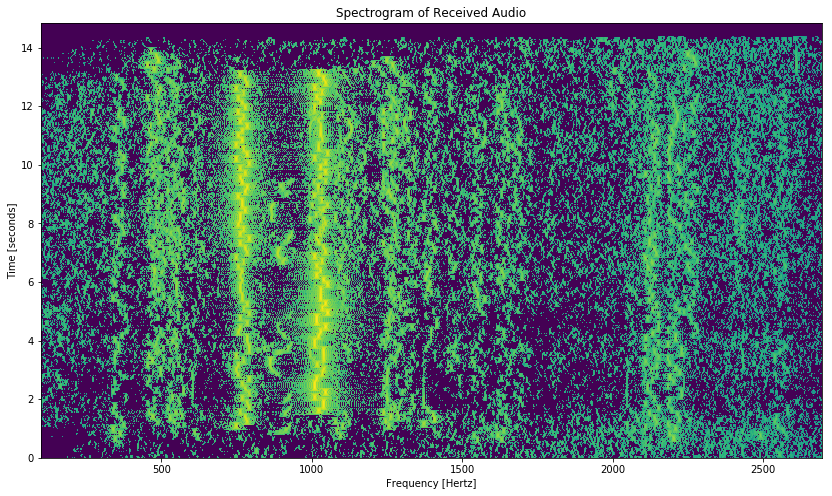

In [43]:
plot_spectrogram(analysis)

### Noise Baseline

WSJT-X uses a smoothed noise baseline to determine the received signal to noise ratio of FT8 signals that are successfully decoded in most instances.
The baseline is calculated by WSJT-X in the `lib/ft8/baseline.f90` compilation unit.

WSJT-X uses the following procedure to determine the noise baseline:

1. The periodograms in the spectrogram are added together to get the total energy in the receiver passband for each frequency.
1. The energy spectrum is divided into 10 segments.
1. Points on the energy spectrum that are less than the 10th percentile within their segment are used to fit a 4th order polynomial curve.
1. The polynomial is evaluated to create the noise baseline.

This notebook uses a variant of the method used by WSJT-X, which can be found in the `_calculate_baseline` static method
of the `ft8.SpectrumAnalysis` class.

The following code illustrates the noise baseline that was determined for the WAV file loaded earlier in this notebook.

In [9]:
def plot_noise_baseline(analysis):
    f = np.linspace(analysis.low_frequency, analysis.high_frequency, analysis.baseline.size)

    plt.figure(figsize=(14, 7))
    plt.title('Noise Baseline')
    plt.xlabel('Frequency (Hertz)')
    plt.ylabel('Power Spectral Density (dB/Hertz)')
    plt.plot(f, analysis.baseline)
    return

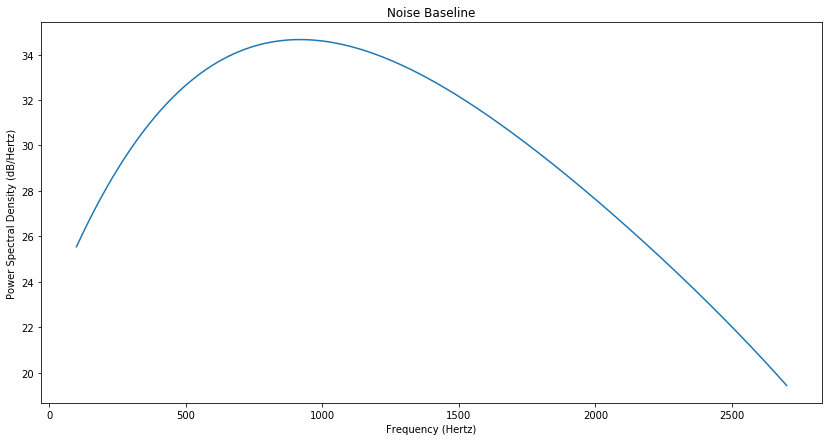

In [10]:
plot_noise_baseline(analysis)

### Costas Array Cross-Correlation

Once the spectrograph has been calculated, WSJT-X attempts to cross-correlate with the Costas arrays that
are embedded in each FT8 signal.
Frequency and time offsets where peaks in the cross-correlation occur are likely candidates for FT8 signals.

There are 3 Costas arrays embedded in each FT8 signal, located at symbol offsets 0, 36 and 72.

As the receiver passband is typically smaller than the Nyquist rate, WSJT-X only performs the
cross-correlation for a subset of frequencies.
The subset of frequencies considered by WSJT-X is specified via the WSJT-X graphical user interface.

In this notebook we choose the subset of frequency bins between 100 Hz and 2700 Hz, which are 
specified using the `low_frequency` and `high_frequency` constants of the `ft8.SpectralAnalysis` class.

WSJT-X attempts to decode FT8 signals that are offset in time by at most 2.5 seconds relative to the local
clock, and this notebook adopts the same behaviour.
This enables communication between two stations with clocks that differ from UTC by +/- 1.25 seconds.
This is because a station with a clock that is 1.25 seconds ahead of UTC,
will observe a time offset of 2.5 seconds,
when receiving signals from a station with a clock that is 1.25 seconds behind UTC.

In [45]:
# Costas array offsets
print("Costas array offsets = {} symbols".format(ft8.costas_offsets))

# Tuning parameters
print("Lowest frequency = {} Hertz".format(ft8.SpectralAnalysis.low_frequency))
print("Highest frequency = {} Hertz".format(ft8.SpectralAnalysis.high_frequency))
print("Time offset search range = +/- {} seconds".format(ft8.SpectralAnalysis.offset_bound))

Costas array offsets = [0, 36, 72] symbols
Lowest frequency = 100 Hertz
Highest frequency = 2700 Hertz
Time offset search range = +/- 2.5 seconds


The result of the Costas array cross-correlation is a matrix that contains a correlation value 
for each frequency and each time offset.
This matrix derived from the WAV file loaded earlier in this notebook is illustrated below.

In [46]:
def plot_correlation():
    offsets, bins = analysis.snr_matrix.shape
    t = np.linspace(-ft8.SpectralAnalysis.offset_bound, ft8.SpectralAnalysis.offset_bound, offsets)
    f = np.linspace(ft8.SpectralAnalysis.low_frequency, ft8.SpectralAnalysis.high_frequency, bins)

    fig = plt.figure(figsize=(14,7))
    ax = fig.gca(projection='3d')
    x, y = np.meshgrid(f, t)

    ax.plot_surface(x, y, np.log(np.clip(analysis.snr_matrix, 3, None)),
                                 linewidth=0, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('Frequency [Hertz]')
    ax.set_ylabel('Time offset [seconds]')
    ax.set_zlabel('Log Correlation')
    ax.set_title('Cross-Correlation of Spectrogram and Costas Arrays')
    plt.show()

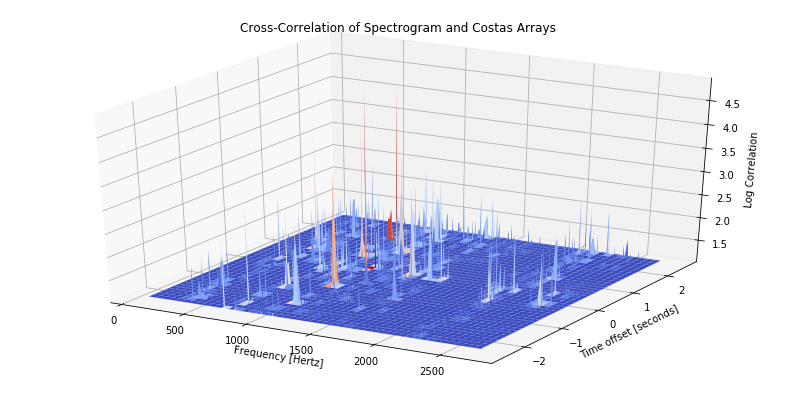

In [47]:
plot_correlation()

### Candidate Selection

Candidate selection is based on the output of the Costas array cross-correlation.

The selection algorithm used by WSJT-X works as follows:

1. For each frequency, determine the time offset where the cross-correlation is maximum.
1. Pick that subset of frequencies that have the highest cross-correlation maximums.
The size of this subset can be controlled by tuning parameters.
1. Eliminate frequencies that are adjacent to frequencies with a higher cross-correlation maximums as these are
unlikely to be genuine FT8 signals.
1. Order the results by frequency.

Each candidate is comprised of a frequency and the time offset where the cross-correlation was maximum for
that frequency.

Candidate selection is performed by WSJT-X in the `lib/ft8/sync8.f90` compilation unit.

In this notebook candidate selection is performed by the `_find_candidates` static method of the `ft8.SignalAnalysis` class
whenever instances of the `ft8.SignalAnalysis` class are created.

The tuning parameters used by WSJT-X and this notebook for performing candidate selection are:

In [32]:
print("Maximum candidates = {}".format(ft8.SpectralAnalysis.max_candidates))
print("Normalization percentile = {}".format(ft8.SpectralAnalysis.normalization_percentile))
print("Candidate threshold = {}".format(ft8.SpectralAnalysis.candidate_threshold))

Maximum candidates = 300
Normalization percentile = 60
Candidate threshold = 1.5


The candidate signals that were identified in the WAV file loaded earlier in this notebook are listed below.

In [37]:
def print_candidates(analysis):
    cols = 3
    for i in range(cols):
        print("Frequency Offset  Sync  ", end='')
    print()
    for i, candidate in enumerate(analysis.candidate_list):
        print("{:9.0f} {:6.1f} {:5.1f}  ".format(candidate[0], candidate[1], candidate[2]), end='')
        if i % cols == cols-1:
            print()

In [38]:
print_candidates(analysis)

Frequency Offset  Sync  Frequency Offset  Sync  Frequency Offset  Sync  
      303   -0.2   8.9        309    1.3  14.0        316    1.1   9.8  
      328    1.9  10.9        341   -0.0  19.8        353   -2.1   7.3  
      359   -1.8   7.1        378   -2.3   6.0        416    0.7  37.2  
      422    0.6  10.5        428    0.3   8.4        434    2.2  11.9  
      453    0.9  59.9        466    1.7   5.8        472    1.6   6.9  
      478    0.6   7.3        484    1.4   6.3        491    1.1   9.5  
      531    0.3  10.7        578    0.1   6.1        603    0.2   8.5  
      712   -2.5  66.6        719   -0.9  39.4        731   -1.3   7.5  
      750    0.1 116.6        762   -1.0   6.2        769   -1.7   7.0  
      775   -0.2  13.0        781    1.7  79.4        788    1.1  80.0  
      794    0.7  62.6        850    0.1  16.4        856   -0.1  11.6  
      872    0.8  16.7        891   -0.5   6.1        909    0.0   7.4  
      916    1.4   9.7        931    0.9   8.9     

## Full Receive Spectrum

Once FT8 candidate signals have been identified, WSJT-X calculates a full receive spectrum of the entire
15 second receive period.
This provides a very high resolution spectrum from which candidate FT8 signals can subsequently be extracted
for further analysis.

WSJT-X performs this calculation as part of the `ft8_downsample` subroutine in the `lib/ft8/ft8_downsample.f90`
compilation unit.

The full receive spectrum calculation uses a 192000 point real DFT based on the received audio for a 15 second
receive period that is then zero padded to a total length of 16 seconds.
The resulting spectrum is comprised of 96001 frequency bins, with a frequency resolution of 0.0625 Hz.

The full receive spectrum for the WAV file loaded earlier in this notebook is displayed below.

In [17]:
def plot_full_receive_spectrum(analysis):
    """Plot the full receive spectrum."""

    # Calculate power spectral density from DFT
    psd = 2.0 * (np.abs(analysis.complex_spectrum) / if_samples.size) ** 2.0 * (if_samples.size / if_sample_rate)
    psd[0] /= 2.0
    psd[psd.size-1] /= 2.0
    f = np.arange(psd.size) * ft8.SpectralAnalysis.spectrum_bin_width

    plt.figure(figsize = (14,8))
    plt.plot(f, 10.0 * np.log10(psd))
    plt.xlabel('Frequency [Hertz]')
    plt.ylabel('Power Spectral Density [dB/Hertz]')
    return

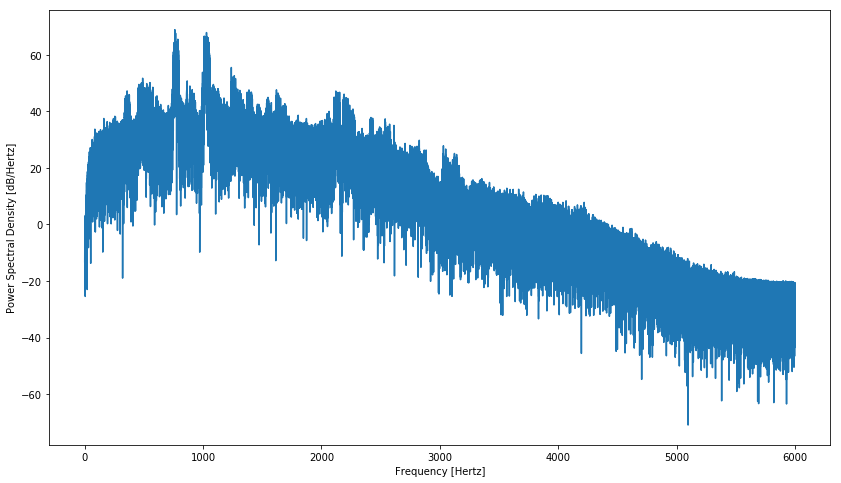

In [18]:
plot_full_receive_spectrum(analysis)

## Candidate Signal Extraction

Once candidate FT8 signals have been identified, WSJT-X extracts each candidate FT8 signal 
from the receiver passband spectrum using filtering and down converts the extracted signal to baseband.
The bandwidth of the baseband signal is approximately 50 Hz, so the sample rate is simultaneously
decimated to 200 Hz or 32 samples per symbol period.

The filtering, down conversion and sample rate decimation is performed by WSJT-X in the subroutine
`ft8_downsample` in the `lib/ft8/ft8_downsample.f90` compilation unit.

The method used by WSJT-X to perform these tasks is as follows:

1. Extract a 62.5 Hz passband corresponding to the candidate signal.
The 62.5 Hz passband is obtained by selecting 1001 frequency bins from the 96001 frequency bins
in the high resolution full spectrum produced after candidate signal identification.
This passband is sufficient to accomodate all 8 tones in an FT8 signal,
along with an extra tone width below and above the candidate FT8 signal.
1. Apply a Tukey (tapered cosine) window with cosine fraction of 1/5th to the extracted passband.
This window only modifies the lowest 1/10th and highest 1/10th of frequency bins in the passband.
The candidate signal itself should be located in the central 8/10ths of the passband,
and therefore is not modified by the window function.
1. Create a new baseband frequency spectrum using a shifted version of the windowed extracted passband.
The baseband frequency spectrum has both positive and negative frequency bins, unlike that produced
by the prior real DFT which only had postive frequency bins.
The baseband frequency spectrum locates the lowest tone in the FT8 signal at the bin corresonding to 0 Hz.
The remaining 7 tones are shifted to frequency bins corresonding to $6.25$ Hz, $12.5$ Hz, $18.75$ Hz, $25$ Hz,
$31.25$ Hz, $37.5$ Hz and $43.75$ Hz.
1. The baseband frequency spectrum is zero padded to achieve the desired sample rate.
Given the 16 second duration of the real DFT and the desired sample rate of 200 Hz the total number of
bins required after padding is $16\times200$ or $3200$.
1. Compute the inverse complex DFT of the baseband frequency spectrum to get the complex baseband
signal.
This will result in 3200 complex samples in the time domain or 16 seconds of samples at 200 samples per second.

In this notebook, candidate FT8 signals are extracted from the full spectrum
whenever instances of the `ft8.Signal` class are created.
The constructor for the `ft8.Signal` class extracts a single candidate FT8 signal from an instance of
the `ft8.SignalAnalysis` class using the `_extract_baseband` function of the `ft8.Signal` class.
The constructor for the `ft8.Signal` class then does further processing which is described later
in this notebook.

The following code attempts to process each candidate signal.
Those candidates that are successfully decoded are appended to the `signals` array.

In [19]:
%%time
# Only use one symbol at a time when depmapping to speed things up a bit
ft8.Signal.demap_max_symbols = 1

# Work around IPython bug/feature when using cell magic to time execution
global signals
signals = []

# Loop through candidates and try to create instances of the Signal class
for i, candidate in enumerate(analysis.candidate_list):
    try:
        s = ft8.Signal(candidate, analysis)
        # Decode of this candidate was successful
        signals.append(s)
    except ValueError:
        # Decode of this candidate was not successful
        pass
    
print("Good candidates = ", len(signals))
print("Bad candidates = ", len(analysis.candidate_list) - len(signals))

Good candidates =  12
Bad candidates =  90
CPU times: user 1.06 s, sys: 5.78 ms, total: 1.07 s
Wall time: 1.06 s


Here is the extracted spectrum for one of the candidate signals that was successfully decoded.

In [20]:
def plot_candidate_spectrum(signal):
    freqs = np.fft.fftfreq(signal.spectrum.size) * 200
    
    psd = (np.abs(signal.spectrum) / signal.spectrum.size) ** 2.0
    
    plt.figure(figsize = (14,8))
    plt.title('Extracted Candidate FT8 Signal')
    plt.xlabel('Frequency [Hertz]')
    plt.ylabel('Power [dB]')
    plt.plot(freqs, 10 * np.log10(np.clip(psd, 1, None)))

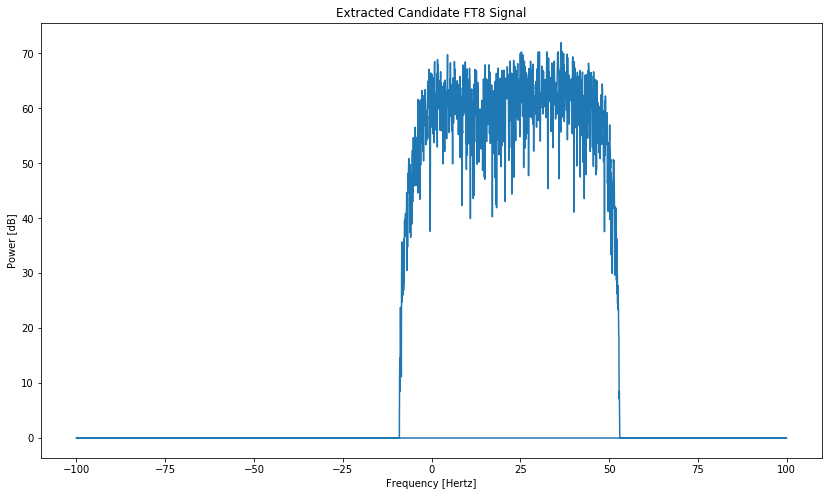

In [21]:
plot_candidate_spectrum(signals[1])

## Frequency Correction and Time Offset Estimation

The original candidate signal identification process was only able to estimate the frequency of a
candidate FT8 signal with a resolution of half the M-GFSK tone separation which is 3.125 Hz,
and estimate the time offset of a candidate FT8 signal with a resolution of 1/4 of the symbol
duration or 1/25th of a second.

Once each candidate FT8 signal has been down converted to baseband, 
WSJT-X performs a second higher resolution estimate of
the frequency and time offset.
The resolution of the high resolution frequency estimate is 0.5 Hz and the resolution of the
high resolution time offset estimate is one baseband sample or 1/200th of a second.

Once a higher resolution frequency estimation is obtained, a further frequency conversion can be applied
to the baseband candidate FT8 signal to ensure that the lowest tone of the FT8 signal is aligned with 0 Hz
as closely as possible.

These tasks are performed in WSJT-X within the `ft8b` subroutine which is defined in the
`lib/ft8/ft8b.f90` compilation unit.

WSJT-X performs the following adjustments:
1. Calculate an improved high resolution time offset estimate.
1. Calculate an improved high resolution frequency estimate after the improved time offset has been applied.
1. Perform a frequency conversion on the baseband candidate FT8 signal to correct any change in the frequency
estimate from that used when the candidate signal was down converted to baseband.

The `ft8b` subroutine depends on several other subroutines:
1. The `sync2d` subroutine in the `lib/ft8/sync2d.f90` compilation unit is used to determine how well a
baseband candidate FT8 signal cross-correlates with the Costas array for a particular frequency and time offset.
1. The `twkfreq1` subroutine in the `lib/ft8/twkfreq1.f90` compilation unit is used to correct the baseband
candidate FT8 signal with a frequency offset to ensure the lowest M-GFSK tone is located at 0 Hz.

Unlike the earlier frequency and time offset estimation process which was performed using correlation
with the Costas array in the frequency domain,
the high resolution frequency correction and time offset estimation process is performed using
correlation with the Costas array in the time domain.

Correction of the frequency is performed by multiplying (heterodyning) with a complex reference signal that
is based on the required frequency correction.

In this notebook high resolution estimation of frequency and time offset is performed whenever instances
of the `ft8.Signal` class are created using the `_refine_estimates` function of the `ft8.Signal` class.
The final corrected frequencies and time offsets for the successfully decoded FT8 signals that were contained
in the WAV file loaded previously are listed below.

In [48]:
print("Signal Offset Frequency SNR")
for i, s in enumerate(signals):
    print("{:6d} {:5.1f}s {:7.0f}Hz {:3.0f}".format(i, s.offset, s.freq, s.snr))

Signal Offset Frequency SNR
     0   0.0s     340Hz -10
     1   0.9s     454Hz  -6
     2   0.1s     749Hz   4
     3   0.2s    1010Hz   6
     4   0.2s    1372Hz -10
     5   0.7s    1447Hz -18
     6   0.1s    1532Hz -13
     7   0.1s    1614Hz -11
     8   0.2s    2048Hz -16
     9   0.1s    2110Hz  -5
    10   0.2s    2185Hz  -5
    11   0.8s    2238Hz  -9


The frequency corrected baseband signal for one of the signals extracted from the WAV file loaded earlier in
this notebook is illustrated below.

In [23]:
def plot_corrected_baseband(signal):
    t = np.linspace(ft8.start_delay, ft8.start_delay + ft8.total_symbols / ft8.baud_rate, signal.baseband.size )
    plt.figure(figsize = (14,8))
    plt.title('Frequency Corrected FT8 Baseband Signal')
    plt.xlabel('Time (s)')
    plt.plot(t[:600], np.real(signal.baseband[:600]))

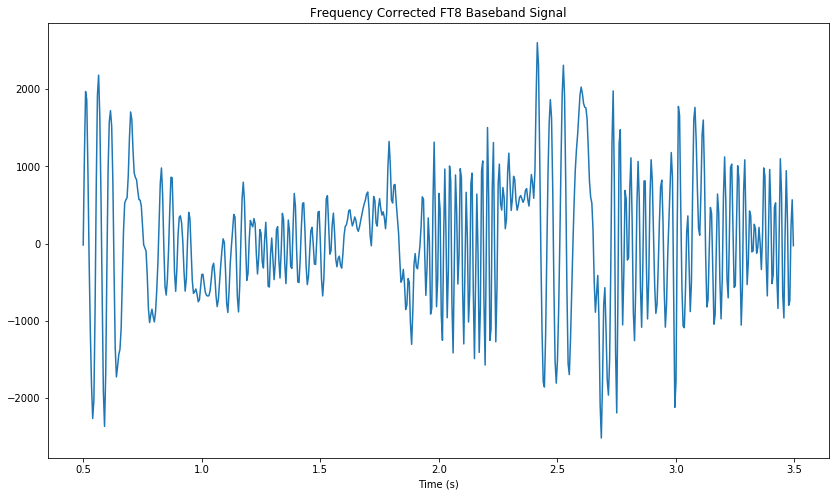

In [24]:
plot_corrected_baseband(signals[1])

## Detection

The detector in a receiver is responsible for determining the unmodulated information that was originally
sent by the transmitter as accurately as possible.
For FT8 signals, the receiver detector attempts to:

1. Determine which of the M (where M=8) possible tones were sent by the transmitter in each symbol period.
2. Remove the gray code mapping that was applied immediately prior to M-GFSK modulation.
3. Identify the bits that were combined into each M-ary symbol.

Once all 179 bits in an encoded message have been detected, the LDPC
decoder can then process these bits
(some of which may be in error) to recreate the original unencoded message.

In digital communication systems there are two broad categories of detectors:

* Hard detectors make a firm decision about the bits that were sent by the transmitter.
Such detectors uses a decision rule to determine whether a particlar bit is a 0 or 1.
* Soft detectors defer the final decision a subsequent decoder,
and instead calculate statistics about the received signal,
which are subsequently provided as input to the decoder.

In WSJT-X, both hard and soft detection methods are used:

* Hard detection is used to perform a sanity check on candidate FT8 signals with the goal of eliminating
those candidates that are unlikely to be decoded successfully.
* Soft detection is used on candidate FT8 signals that pass the sanity check to generate a statistic
called the log likelihood ratio (LLR) that can be used by a decoder.
The LLR is described in more detail in the [FT8 Coding](Coding.ipynb) notebook.

The use of soft detection generally enables communication to be maintained at lower signal to noise
ratios than is possible with hard detection.
This is because the decoder can use the information that would otherwise be lost when a hard detection
decision is made.

WSJT-X performs detection in the `ft8b` subroutine which is in the `lib/ft8/ft8b.f90` compilation unit.

In this notebook, detection is performed by the `_detect` function within the `ft8.Signal` class.
This function is called within the constructor of the `ft8.Signal` class.

### Demodulation and Costas Array Hard Detection

The first step in detection is demodulation of the M-GFSK baseband signal.
In WSJT-X demodulation is performed using the discrete Fourier transform (DFT).
The DFT is used as a filter bank, with one bandpass filter per M-GFSK tone.

A a total of 79 DFTs (one for each symbol) are calculated for each candidate FT8 signal, 
with each DFT processing 32 baseband complex samples.
The sample rate for the down converted basebase signal is 200 samples per second, and therefore the
DFT bin width is 200/32 or 6.25 Hz, which is the M-GFSK tone separation used by FT8.
The down converted baseband signal places the lowest M-GFSK tone at 0 Hz, and therefore the
lowest M DFT bins correspond with the M tones used by the M-GFSK modulation.

The output of the DFTs are directly used by WSJT-X to perform hard detection.
The decision rule used by WSJT-X for hard detection chooses as the received symbol that
which corresponds to the DFT frequency bin with the largest magnitude.

WSJT-X only performs hard detection on the 21 symbol periods that correspond to the Costas arrays
embedded in each FT8 signal.
The detected symbols are compared with the corresponding Costas arrays to determine how many match.
The sanity check used by WSJT-X requires at least one third of the detected symbols to have matched.
Candidate FT8 signals that do not pass the sanity check receive no further processing as they are
unlikely to be decoded successfully.

The following examples show the output of the demodulator for the first 12 symbol periods for two of the signals
that were successfully decoded from the WAV file loaded earlier in this notebook.
The first 7 of these should match the Costas array.
Note that in the second example the signal was successfully decoded despite the first 3 Costas symbols being absent.

In [25]:
def plot_obs(signal):
    rows = 3
    cols = 4
    print(ft8.costas[:(rows * cols)]) # The peaks should match these values if there is no noise
    fig, axes = plt.subplots(rows, cols, True, True, figsize = (14,8))
    
    for r in range(rows):
        for c in range(cols):
            s = r * cols + c
            axes[r, c].set_title('Symbol ' + str(s))
            axes[r, c].bar(np.arange(8), np.abs(signal.obs[s]))
            
    plt.show()

[3, 1, 4, 0, 6, 5, 2]


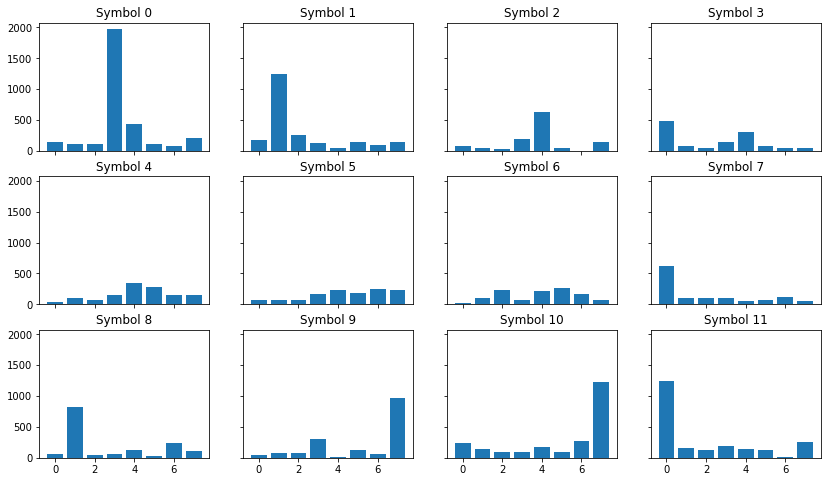

In [26]:
plot_obs(signals[1])

[3, 1, 4, 0, 6, 5, 2]


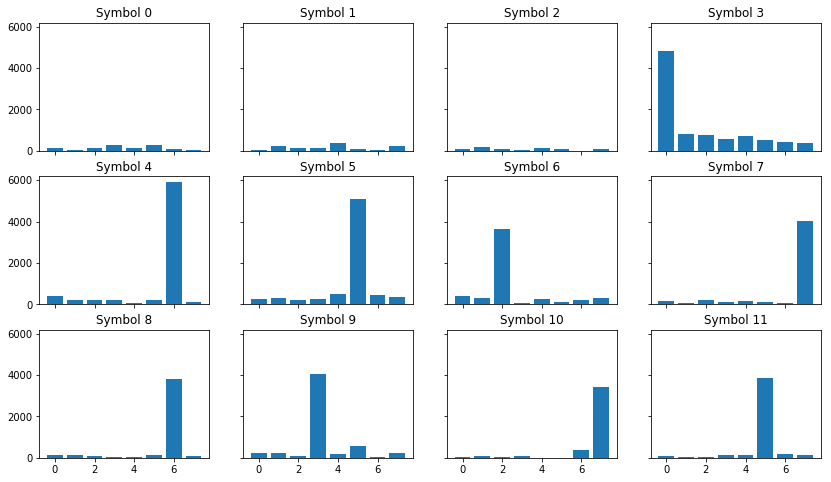

In [27]:
plot_obs(signals[2])

### Soft Demapping

Soft demapping is the process of taking the output of the M-GFSK demodulator and 
estimating a statistic called the log likelihood ratio (LLR) for each
encoded bit position.
The LLR is described in more detail in the [FT8 Coding](Coding.ipynb#Log-Likelyhood-Ratio) notebook.

The WSJT-X demapper can combine observations from one, two or three symbols at a time when estimating LLRs.
The each of the resulting sets of LLRs are used for different decoding passes.

In this notebook, the demapping is performed by the `_demap` function in the `ft8.Signal` class.

#### Demapper Algorithm

Precise determination of the probability density functions needed to calculate the LLR
is not possible without a detailed knowledge of the noise and distortions
introduced by the communication channel between the transmitter and receiver.
In general, the type of noise and other distortions introduced by the communication channel are unknown.

Therefore demappers need to make assumptions about the communication channel, and combine this with
specifics of the modulation method, to derive suitable probability density functions.
In many cases demappers also use simplifications in the LLR calculation in order to reduce
computational complexity.

Unfortunately the WSJT-X source code does not include any information about the assumptions
and simplifications that are behind the design of the demapper algorithm.
Therefore, it is described below without any rational.

The demapper algorithm processes the 79 symbol observations in groups of one, two or three symbols to produce
three sets of LLRs.

The algorithm begins by iterating through all possible symbol permutations for each symbol group and
calculating a coherent (complex) sum of the symbol observations that correspond to each symbol permutation
after gray coding.

The algorithm then iterates through all possible encoded bit positions and calculates an unnormalised LLR for
each bit.
The unnormalised LLR is taken as the difference between the maximum magnitude of the sums corresponding to symbol
permutations where the bit is a one, and the maximum magnitude of the sums corresponding to symbol permutations
where the bit is a zero.

Finally the algorithm normalises the LLRs by dividing them by their standard deviation and multiplying by
a fudge factor of 2.83 (which is approximately the square root of eight).

The following example shows the output of the demapper and the corresponding bit values that were subsequently
decoded from the demapper output for a signal that was successfully decoded from the WAV file loaded earlier in
this notebook.

In [28]:
def plot_llr(signal, bits):
    print("{:077b}".format(signal.msg.pack77))
    llr = np.broadcast_to(signals[1].llr[:bits, np.newaxis], (bits, 32)).reshape(bits * 32)
    pos = np.linspace(0, bits, bits * 32)
    plt.figure(figsize = (14,8))
    plt.title('Soft Demapper Output')
    plt.xlabel('Bit Position')
    plt.ylabel('Log Likelyhood Ratio')
    plt.plot(pos, llr)

00000111111100001000110111000100011111101110101100111110000110111001011011001


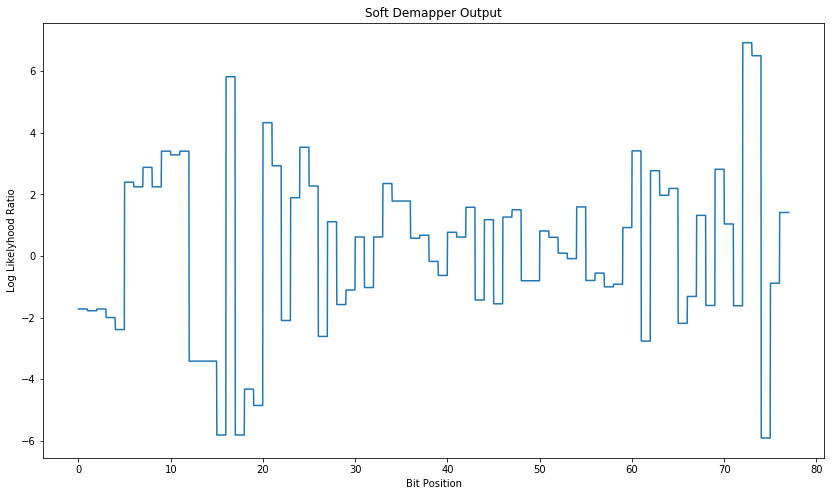

In [29]:
plot_llr(signals[1], 77)

## LDPC Decoding and CRC Check

The FT8 digital mode uses an error detection and correction code
to correct errors that may occur when a FT8 signal traverses a noisy
communication channel.
The specific code used by FT8 is known as a low-density parity-check (LDPC) code.

Since LDPC codes were first described by Gallager
[[3]](#References) in the early 1960s, there have been multiple methods
disclosed in the information theory literature for decoding these codes.
WSJT-X incorporates two such methods:

1. Sum-product algorithm (also called "belief propagation")
1. Ordered statistics

The primary decoding method used by WSJT-X is the sum-product algorithm, which can be found in the
`lib/ft8/bpdecode174_91.f90` compilation unit.
The sum-product algorithm operates by passing messages across a factor graph that represents the parity
check equations of the LDPC code.
This is illustrated in the diagram below:

![Sum Product Algorithm](drawings/Sum%20Product.svg)

When deep decoding is enabled, WSJT-X will also use the ordered statistics decoder
to decode FT8 signals that could not be decoded sucessfully using the sum-product algorithm.
The WSJT-X implementation of the ordered statistics decoder can be found in the `lib/ft8/osd174_91.f90`
compilation unit.

This notebook only uses the sum-product algorithm, which has been implemented in the
`_sum_product_decoder` static method of the `ft8.Signal` class.

WSJT-X also uses a second code called a cyclic redundancy check (CRC) to detect errors that are
not detected and corrected by the LDPC decoder.
Messages which contain an invalid CRC are discarded.
However, such messages may still be decoded in subsequent 15 second receive periods if they are retransmitted.

More details on LDPC decoding, the sum-product algorithm and CRCs can be found in the
[FT8 Coding](Coding.ipynb) notebook.

## Source Decoding

The final step in receiving FT8 signals is to unpack the 77 bit messages into the original message text.
This process is called source decoding in the information theory literature.

In the WSJT-X source code, source decoding is performed by subroutines in the `lib/77bit/packjt77.f90` compilation unit.

In this notebook, source decoding is performed by the `unpack77` class methods of the `ft8.Message` class and associated
subclasses.
These methods are invoked whenever instances of the `ft8.Signal` class are created.

More details on the source encoding used by WSJT-X can be found in the [FT8 Packing](Packing.ipynb) notebook.

The following example shows the source encoded bits and corresponding messages that were decoded from those
bits for each of the FT8 signals that were in the WAV file that was processed by this notebook.

In [30]:
for s in signals:
    print("{:077b} {}".format(s.msg.pack77, s.msg))

00000111111100001000110111000100100100101001000110011100100111111010101000001 StandardMessage(A5A JR7AMZ -11)
00000111111100001000110111000100011111101110101100111110000110111001011011001 StandardMessage(A5A JE6ENG PM51)
11110101011110001011100100000111000011111110110100101110101111111010101001001 StandardMessage(YF9CDL VK1HMS R-10)
10010000010100000000111010000110010010000000001101010100100111111010101001001 StandardMessage(JH0ASH RV0AR -10)
00000000000000000000000000100010110100101111011011011111100110011101100111001 StandardMessage(CQ BH6JOX OM71)
00000111111100001000110111000110010010011000111011100100000111011000110011001 StandardMessage(A5A RW0IM QO59)
00000111111100001000110111000100011110001110011010101011100110111001011101001 StandardMessage(A5A JA6CNL PM53)
10001111000110010101010110110001110010001000111011000101100111111010101111001 StandardMessage(JA5JWQ 6K2ILX -04)
00000000000000000000000000100000010011101111010001001101000001100111110011001 StandardMessage(CQ K7VNE DM43)


## References

1. https://physics.princeton.edu/pulsar/k1jt/wsjtx.html
1. J. P. Costas, “Medium constraints on SONAR design and performance,” GE Co., Class 1 Rep. R65EMH33, Nov. 1965.
1. R. G. Gallager, "Low-Density Parity-Check Codes," IRE Transactions on Information Theory, vol. 8, pp. 21-28, Jan. 1962.

## License
Copyright (C) 2019 James Kelly, VK3JPK.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.